In [3]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
from utils import create_trips_df

In [4]:
rt_to_pid = pl.read_parquet('rt_to_pid.parquet')

trips_df = create_trips_df(rt_to_pid, ['55'])
group = ('hour', '1h')
trips_df = trips_df.with_columns(pl.col("bus_stop_time").dt.truncate(group[1]).alias(group[0]))
buses_by_day = trips_df.group_by(["rt", 'stop_id', group[0]]).agg(pl.col("bus_stop_time").count().alias("num_trips"))
buses_by_day  = buses_by_day.with_columns(pl.col("rt").cast(pl.String))

trips_df = create_trips_df(rt_to_pid, ['55'], is_scheduled=True)

trips_df = trips_df.with_columns(pl.col("bus_stop_time").dt.truncate(group[1]).alias(group[0]))
schedule_by_day = trips_df.group_by(["rt",'stop_id', group[0]]).agg(pl.col("bus_stop_time").count().alias("num_trips"))

Do not have pattern 20424 for route. Skipping


In [5]:
join = schedule_by_day.join(buses_by_day, on=['rt','stop_id','hour'], how="inner")
join = join.rename({"num_trips": "num_trips_sched", "num_trips_right": "num_trips_actual"})



In [6]:
join

rt,stop_id,hour,num_trips_sched,num_trips_actual
str,str,datetime[ns],u32,u32
"""55""","""10611""",2023-12-22 09:00:00,5,5
"""55""","""10618""",2023-04-02 09:00:00,3,3
"""55""","""10519""",2023-01-19 11:00:00,5,5
"""55""","""10530""",2023-12-03 11:00:00,5,4
"""55""","""10526""",2023-05-02 15:00:00,6,6
…,…,…,…,…
"""55""","""10583""",2023-01-25 01:00:00,2,2
"""55""","""17563""",2023-03-01 19:00:00,4,4
"""55""","""10632""",2023-01-01 01:00:00,2,1


In [8]:
one_day_onestop = join.filter((pl.col("hour").dt.truncate('1d') == pl.lit("2023-12-18 00:00:00").str.strptime(pl.Datetime, format = "%Y-%m-%d %H:%M:%S")) & (pl.col("stop_id") == '10604'))

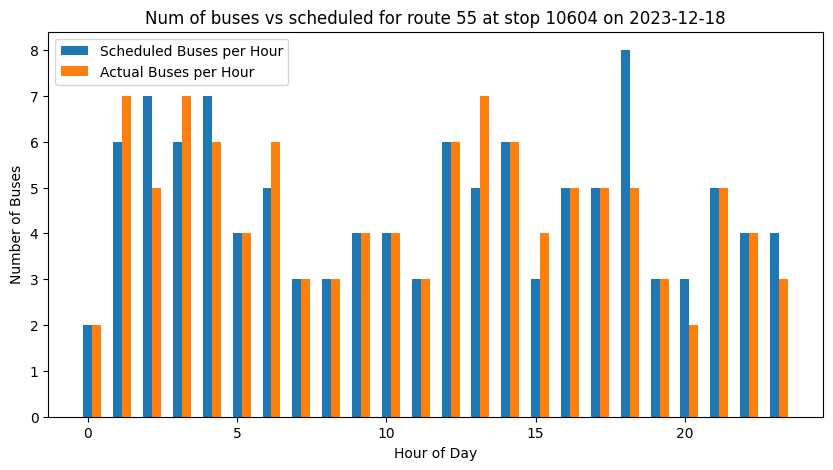

In [9]:

# Numbers of pairs of bars you want
N = one_day_onestop.select('hour').n_unique()

# Data on X-axis

# Specify the values of blue bars (height)
schedule_bar = one_day_onestop.select('num_trips_sched').get_columns()[0].to_list()
# Specify the values of orange bars (height)
actual_bar = one_day_onestop.select('num_trips_actual').get_columns()[0].to_list()

# Position of bars on x-axis
ind = np.arange(N)

# Figure size
plt.figure(figsize=(10,5))

# Width of a bar 
width = 0.3       

# Plotting
plt.bar(ind, schedule_bar , width, label='Scheduled Buses per Hour')
plt.bar(ind + width, actual_bar, width, label='Actual Buses per Hour')

plt.xlabel('Hour of Day')
plt.ylabel('Number of Buses')
plt.title('Num of buses vs scheduled for route 55 at stop 10604 on 2023-12-18')

# xticks()
# First argument - A list of positions at which ticks should be placed
# Second argument -  A list of labels to place at the given locations

# Finding the best position for legends and putting it
plt.legend(loc='best')
plt.show()